In [4]:
import pandas as pd
import datetime as dt
import numpy as np
from factor_analyzer import FactorAnalyzer, Rotator, calculate_kmo

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.anova import anova_lm

from scipy import stats
from scipy.stats import pearsonr

# Background

This project is to investigate the relationship between e-service quality model and customer satisfaction of instant delivery services with app-based and on-demand characteristics through analysing data collected from questionnaires. 

The e-service quality model for customer satisfaction (SAT) consists of four dimensions including app design, delivery fulfillment, customer service, and security/privacy, which are constituted by eleven lower order constructs: 
1. The dimension of app design includes app aesthetics (AA), booking convenience (BC), service choice (SC), price offerings (PO), and system functionality (SF).
2. The dimension of delivery fulfillment includes timeliness of delivery (TD) and order reliability (OR). 
3. The dimension of customer service includes couriers performance (CP) and feedback mechanism (FM). 
4. The dimension of security/privacy includes security (SEC) and privacy (PRI).

Four hypotheses will be examined in this study:
1. H1 - Perceptions of app design directly contribute to customer satisfaction.
2. H2 - Perceptions of delivery fulfillment directly contribute to customer satisfaction.
3. H3 - Perceptions of customer service directly contribute to customer satisfaction.
4. H4 - Perceptions of security/privacy directly contribute to customer satisfaction.

The complete report of the study can be found in this link:
https://drive.google.com/file/d/19aE3VYPbTaix56qzSoiLPPkrlofAuK2M/view?usp=sharing

### Raw data from the Questionnaire

In [2]:
# Extracting raw data
data = pd.read_excel("Data_Questionnarie.xlsx", sheet_name="Raw Data")
data.head(3)

,時間戳記,請問您有否使用過GOGOVAN或LALAMOVE的服務？,介面外觀 [此程式視覺上令我滿意],介面外觀 [此程式的版面設計令我滿意],介面外觀 [我認為此程式在視覺上是吸引的],預約方便程度 [瀏覽貨物明細、價格等預約信息是容易的],預約方便程度 [我在預約和付款時沒有困難],預約方便程度 [此程式將我的訂單快速地交托給司機],服務選擇 [此程式可以選擇公司聲稱擁有的送貨服務],服務選擇 [此程式的服務類型能符合我的要求],...,口碑 [對尋求我建議的人，我推薦該公司],口碑 [我鼓勵朋友和其他人公司享用的送貨服務。],在一個月內，您曾使用過多少次以下送貨服務？ [GOGOVAN],在一個月內，您曾使用過多少次以下送貨服務？ [LALAMOVE],性別,年齡,每月收入,教育程度,您的職業是什麼？,您居住在甚麼地區?
0,2019-01-28 22:56:45.344000,有,4 同意,4 同意,3 中立,4 同意,4 同意,3 中立,4 同意,4 同意,...,4 同意,3 中立,1-3次,1-3次,男,18-30歲,$10000以下,專上教育,全職學生,NaN
1,2019-01-28 22:57:06.377000,無,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-29 10:12:10.173000,有,4 同意,4 同意,4 同意,4 同意,4 同意,4 同意,4 同意,4 同意,...,4 同意,4 同意,7-9次,7-9次,女,31-40歲,$10000-$15999,小學或以下,零售、住宿及膳食服務從業員,NaN


### Transformation of data foramt for further analysis

In [3]:
# Renaming the columns
data.columns = ["Timestamp", "Y/N", "AA1", "AA2", "AA3", "BC1", "BC2", "BC3", "SC1", "SC2", "SC3", "PO1", "PO2", "PO3", "SF1", "SF2", "SF3", "TD1", "TD2", "TD3", "OR1", "OR2", "OR3", "CP1", "CP2", "CP3", "FM1", "FM2", "FM3", "SEC1", "SEC2", "SEC3", "PRI1", "PRI2", "PRI3", "SAT1", "SAT2", "SAT3", "RI1", "RI2", "RI3", "WM1", "WM2", "WM3", "Times_GOGOVAN", "Times_LALAMOVE", "Gender", "Age", "Monthly_Income", "Education_Level", "Occupation", "Living_District"]

# Renaming and quantifying the data 
data = data.replace({"有": "Y",
              "無": "N",
              "1 非常不同意": 1,
              "2 不同意": 2,
              "3 中立": 3,
              "4 同意": 4,
              "5 非常同意": 5,
              "0次": "0 time",              
              "1-3次": "1-3 times",
              "4-6次": "4-6 times",
              "7-9次": "7-9 times",
              "10次或以上": "10 times of above",
              "男": "Male",
              "女": "Female",
              "18-30歲": "18-30",
              "31-40歲": "31-40",
              "41-50歲": "41-50",
              "51-60歲": "51-60",
              "61歲或以上": "61 or above",
              "$10000以下": "<= 10000",
              "$10000-$15999": "10000-15999",
              "$16000-$29999": "16000-29999",
              "$30000-$39999": "30000-39999",
              "$40000或以上": ">= 40000",
              "小學或以下": "Primary level or below",
              "初中": "Junior secondary level",
              "高中": "Senior secondary level",
              "專上教育": "Tertiary level",
              "大學或以上": "University level or above",
              "全職學生": "Full-time student",
              "其他行業": "Others",
              "無業或待業人士": "Unemployed",
              "公共行政、社會、個人及醫護服務從業員": "Public administration, individual & medical industry",
              "金融、保險、地產、專業及商用服務從業員": "Finance, insurance, real estate & professional industry",
              "建造業從業員": "Construction industry",
              "教育行業": "Education industry",
              "進出口貿易及批發從業員": "Import & export trade & wholesale industry",
              "運輸、倉庫、郵政及速遞服務、資訊及通訊從業員": "Transportation, warehousing, express, IT industry",
              "零售、住宿及膳食服務從業員": "Retailing, accommodation & catering industry",
              "製造業從業員": "Manufacturing industry",
              "新界西": "New Territories West",
              "新界東": "New Territories East",
              "九龍西": "Kowloon West",
              "九龍東": "Kowloon East",
              "香港島": "Hong Kong Island",
              
             })

# Changing the data type to category as to save the storing space
data["Gender"] = data["Gender"].astype("category")
data["Times_GOGOVAN"] = data["Times_GOGOVAN"].astype("category")
data["Times_LALAMOVE"] = data["Times_LALAMOVE"].astype("category")
data["Age"] = data["Age"].astype("category")
data["Monthly_Income"] = data["Monthly_Income"].astype("category")
data["Education_Level"] = data["Education_Level"].astype("category")
data["Occupation"] = data["Occupation"].astype("category")
data["Living_District"] = data["Living_District"].astype("category")

# Filtering the useful data for analysis
data = data[data["Y/N"] == "Y"]
data.head(3)

,Timestamp,Y/N,AA1,AA2,AA3,BC1,BC2,BC3,SC1,SC2,...,WM2,WM3,Times_GOGOVAN,Times_LALAMOVE,Gender,Age,Monthly_Income,Education_Level,Occupation,Living_District
0,2019-01-28 22:56:45.344000,Y,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,4.0,3.0,1-3 times,1-3 times,Male,18-30,<= 10000,Tertiary level,Full-time student,NaN
2,2019-01-29 10:12:10.173000,Y,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,7-9 times,7-9 times,Female,31-40,10000-15999,Primary level or below,"Retailing, accommodation & catering industry",NaN
9,2019-02-02 16:30:53.482000,Y,4.0,4.0,2.0,4.0,4.0,5.0,5.0,4.0,...,4.0,4.0,1-3 times,0 time,Male,18-30,10000-15999,University level or above,Others,New Territories West


In [4]:
# Unifying the unit of the Timestamp column
temporarylist = []
for i in data.loc["763":"779", "Timestamp"].values:
    temporarylist.append(pd.to_datetime(i[0:8] + i[11:]))
data.loc["763":"779", "Timestamp"] = (pd.Series(data = temporarylist, index = data.index[-9:]))
data.loc["763":"779", "Timestamp"] = pd.to_datetime(data.loc["763":"779", "Timestamp"]) + pd.DateOffset(hours = 12)

data.loc["0":"759", "Timestamp"] = pd.to_datetime(data.loc["0":"759", "Timestamp"], unit="ns")
data["Timestamp"] = pd.to_datetime(data["Timestamp"])
data["Timestamp"]
data

,Timestamp,Y/N,AA1,AA2,AA3,BC1,BC2,BC3,SC1,SC2,...,WM2,WM3,Times_GOGOVAN,Times_LALAMOVE,Gender,Age,Monthly_Income,Education_Level,Occupation,Living_District
0,2019-01-28 22:56:45.344,Y,4.0,4.0,3.0,4.0,4.0,3.0,4.0,4.0,...,4.0,3.0,1-3 times,1-3 times,Male,18-30,<= 10000,Tertiary level,Full-time student,NaN
2,2019-01-29 10:12:10.173,Y,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,7-9 times,7-9 times,Female,31-40,10000-15999,Primary level or below,"Retailing, accommodation & catering industry",NaN
9,2019-02-02 16:30:53.482,Y,4.0,4.0,2.0,4.0,4.0,5.0,5.0,4.0,...,4.0,4.0,1-3 times,0 time,Male,18-30,10000-15999,University level or above,Others,New Territories West
12,2019-02-03 12:06:05.065,Y,4.0,3.0,3.0,4.0,3.0,4.0,4.0,3.0,...,4.0,4.0,0 time,0 time,Female,18-30,<= 10000,University level or above,Full-time student,New Territories East
15,2019-02-03 13:22:28.820,Y,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,4.0,4.0,7-9 times,7-9 times,Female,51-60,<= 10000,University level or above,Manufacturing industry,New Territories East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,2019-03-01 15:58:34.000,Y,3.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,...,3.0,3.0,1-3 times,1-3 times,Female,31-40,16000-29999,University level or above,Manufacturing industry,New Territories East
772,2019-03-01 16:00:23.000,Y,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,3.0,1-3 times,0 time,Male,18-30,10000-15999,University level or above,Full-time student,Hong Kong Island
776,2019-03-01 16:02:38.000,Y,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,3.0,4.0,1-3 times,0 time,Male,18-30,10000-15999,Tertiary level,Construction industry,New Territories West
777,2019-03-01 16:03:53.000,Y,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,3.0,4.0,4-6 times,0 time,Male,41-50,30000-39999,University level or above,"Public administration, individual & medical in...",New Territories East


### Trend during the Questionnaire Collection Period

Plotting a graph to show the cumulative frequency of questionnaire collected between 29 Jan 2019 and 1 Mar 2019

2019-01-28     1
2019-01-29     1
2019-02-02     1
2019-02-03     4
2019-02-04     1
2019-02-07     5
2019-02-08    32
2019-02-09    18
2019-02-10    39
2019-02-11    25
2019-02-18     4
2019-02-19     9
2019-02-20    17
2019-02-21    15
2019-02-22    29
2019-03-01     9
dtype: int64


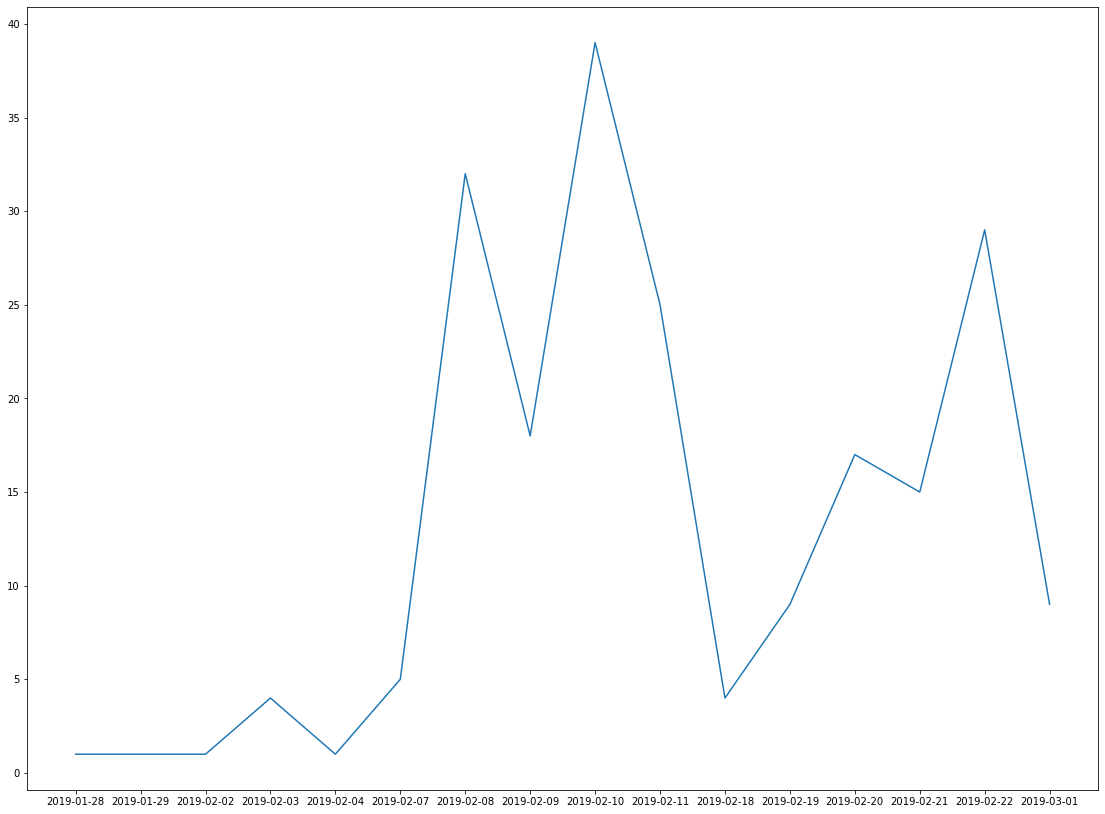

In [5]:
# Preparing settings of the graph 
plt.figure(figsize=(19.2, 14.4))
temporarylist = []
data_time = []

# Extracting the date from the Timestamp column and counting its value
for i in data["Timestamp"]:
    temporarylist.append(str(i))
for i in temporarylist:
    data_time.append(i[0:10])
data_time = pd.Series(data_time).value_counts()

# Sorting the value according to its time as the index
data_time.sort_index(ascending = True, inplace = True)

# Printing the result and its graph
print(data_time)
plt.plot(data_time)

Hence, 10 Feb 2019 is the day that collects the largest number of questionnaire results (39 units). 

# Demographic Data of the Respondents

The questionnaire was made by the Google Form. Hundreds of questionnaires was delivered on the online platform and by hand like friends, families or the groups. Eventually, 210 pieces of questionnaire were received at the end of the survey.

### Distribution of Gender

        Frequency  Percentage
Male          107        0.51
Female        103        0.49


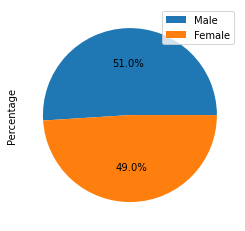

In [6]:
# Extracting data from the Gender column and counting its value to a new dataframe with a Frequency column and a Percentage column
data_gender = pd.DataFrame(data = data["Gender"].value_counts())
data_gender.columns = ["Frequency"]
data_gender.insert(loc = 1, column = "Percentage", value = 0)

# Calculating the percentage for each gender group from the Frequency column and inputting them into the Percentage column
Male_percentage = data_gender.loc["Male", "Frequency"] / (data_gender.loc["Male", "Frequency"] + data_gender.loc["Female", "Frequency"])
Female_percentage = data_gender.loc["Female", "Frequency"] / (data_gender.loc["Male", "Frequency"] + data_gender.loc["Female", "Frequency"])
data_gender["Percentage"] = float(data_gender.loc["Male", "Percentage"])

# Printing the result after rounding the percentage
data_gender.loc["Male", "Percentage"] = round(Male_percentage, 2)
data_gender.loc["Female", "Percentage"] = round(Female_percentage, 2)
print(data_gender)

# Creating the pie chart with the bmh style, the legend on the pie, the deactivation of labels, and the labelling of percentage 
data_gender_pie = data_gender["Percentage"]
data_gender["Percentage"].plot(kind = "pie", style = "bmh", legend = True, labels = None, autopct='%1.1f%%')

Hence, the respondents' gender are almost equally distributed.

### Distribution of Age

             Frequency  Percentage
41-50               68        0.32
18-30               56        0.27
31-40               33        0.16
51-60               32        0.15
61 or above         21        0.10


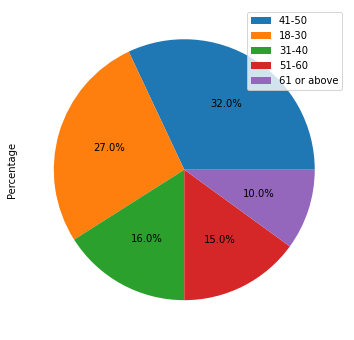

In [7]:
# Extracting data from the Age column and counting its value to a new dataframe with a Frequency column and a Percentage column
data_age = pd.DataFrame(data = data["Age"].value_counts())
data_age.columns = ["Frequency"]
data_age.insert(loc = 1, column = "Percentage", value = 0)

# Calculating the percentage for each age group from the Frequency column and inputting them into the Percentage column
# Printing the result after rounding the percentage
data_age["Frequency"], data_age["Percentage"] = np.array(data_age["Frequency"]), np.array(data_age["Percentage"])
data_age["Percentage"] = round(data_age["Frequency"] / data_age["Frequency"].sum(), 2)
print(data_age)

# Creating the related pie chart with the bmh style, the legend on the pie, the deactivation of labels, and the labelling of percentage 
data_age["Percentage"].plot(kind = "pie", style = "bmh", legend = True, labels = None, figsize = (6, 6), autopct='%1.1f%%')

Almost one-third of the respondents are aged between 41 and 50 years old. 
Together with the respondents aging between 18-30 years old, 
the two groups of respondents contribute to more than a half of the questionnaire results collected.
Hence, neither the young adult's opinion nor the middle-aged's will be ignored by the further analysis.

### Distribution of Monthly Income

             Frequency  Percentage
16000-29999         81        0.39
<= 10000            46        0.22
10000-15999         40        0.19
30000-39999         27        0.13
>= 40000            16        0.08


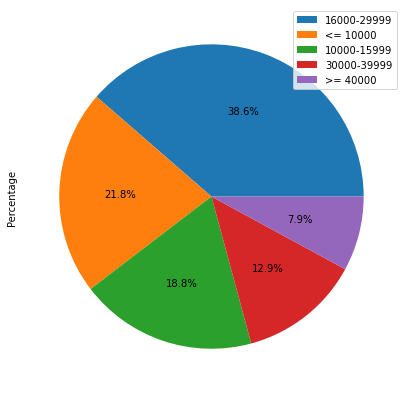

In [8]:
# Extracting data from the Monthly_Income column and counting its value to a new dataframe with a Frequency column and a Percentage column
data_income = pd.DataFrame(data = data["Monthly_Income"].value_counts())
data_income.columns = ["Frequency"]
data_income.insert(loc = 1, column = "Percentage", value = 0)

# Calculating the percentage for each income group from the Frequency column and inputting them into the Percentage column
# Printing the result after rounding the percentage
data_income["Frequency"], data_income["Percentage"] = np.array(data_income["Frequency"]), np.array(data_income["Percentage"])
data_income["Percentage"] = round(data_income["Frequency"] / data_income["Frequency"].sum(), 2)
print(data_income)

# Creating the related pie chart with the bmh style, the legend on the pie, the deactivation of labels, and the labelling of percentage 
data_income["Percentage"].plot(kind = "pie", style = "bmh", legend = True, labels = None, figsize = (7, 7), autopct='%1.1f%%')

Hence, the majority of the respondents earns less than $30000 per month.

### Distribution of Education Level

                           Frequency  Percentage
Senior secondary level            67        0.32
University level or above         63        0.30
Tertiary level                    54        0.26
Junior secondary level            18        0.09
Primary level or below             8        0.04


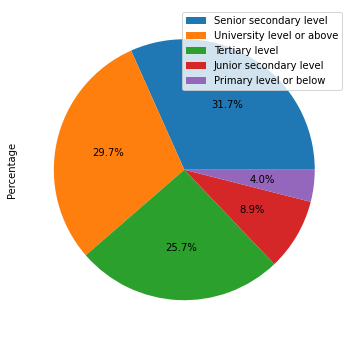

In [9]:
# Extracting data from the Education_Level column and counting its value to a new dataframe with a Frequency column and a Percentage column
data_edu = pd.DataFrame(data = data["Education_Level"].value_counts())
data_edu.columns = ["Frequency"]
data_edu.insert(loc = 1, column = "Percentage", value = 0)

# Calculating the percentage for each education level group from the Frequency column and inputting them into the Percentage column
# Printing the result after rounding the percentage
data_edu["Frequency"], data_edu["Percentage"] = np.array(data_edu["Frequency"]), np.array(data_edu["Percentage"])
data_edu["Percentage"] = round(data_edu["Frequency"] / data_edu["Frequency"].sum(), 2)
print(data_edu)

# Creating the related pie chart with the bmh style, the legend on the pie, the deactivation of labels, and the labelling of percentage 
data_edu["Percentage"].plot(kind = "pie", style = "bmh", legend = True, labels = None, figsize = (6, 6), autopct='%1.1f%%')

Hence, the majority of respondents has at least completed their secondary education.

### Distribution of Occupation

                                                    Frequency  Percentage
Retailing, accommodation & catering industry               35        0.17
Transportation, warehousing, express, IT industry          29        0.14
Import & export trade & wholesale industry                 28        0.13
Construction industry                                      27        0.13
Full-time student                                          22        0.10
Public administration, individual & medical ind...         20        0.10
Finance, insurance, real estate & professional ...         20        0.10
Others                                                     19        0.09
Manufacturing industry                                      5        0.02
Unemployed                                                  3        0.01
Education industry                                          2        0.01


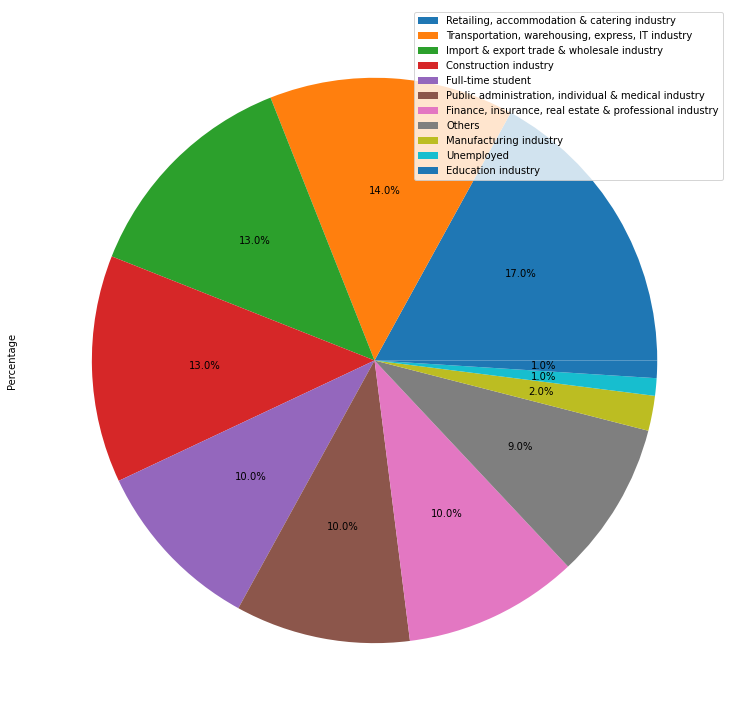

In [10]:
# Extracting data from the Occupation column and counting its value to a new dataframe with a Frequency column and a Percentage column
data_occupation = pd.DataFrame(data = data["Occupation"].value_counts())
data_occupation.columns = ["Frequency"]
data_occupation.insert(loc = 1, column = "Percentage", value = 0)

# Calculating the percentage for each occupation group from the Frequency column and inputting them into the Percentage column
# Printing the result after rounding the percentage
data_occupation["Frequency"], data_occupation["Percentage"] = np.array(data_occupation["Frequency"]), np.array(data_occupation["Percentage"])
data_occupation["Percentage"] = round(data_occupation["Frequency"] / data_occupation["Frequency"].sum(), 2)
print(data_occupation)

# Creating the related pie chart with the bmh style, the legend on the pie, the deactivation of labels, and the labelling of percentage 
data_occupation["Percentage"].plot(kind = "pie", style = "bmh", legend = True, labels = None, figsize = (13, 13), autopct='%1.1f%%')

Hence, the respondents from the retailing, accommodation and catering industry is the largest occupation group while the respondents from the education industry is the smallest occupation group together with the unemployed people.

### Distribution of Living District

                      Frequency  Percentage
Kowloon East                 70        0.33
New Territories West         51        0.24
New Territories East         36        0.17
Kowloon West                 35        0.17
Hong Kong Island             16        0.08
Missing Data                  2        0.01


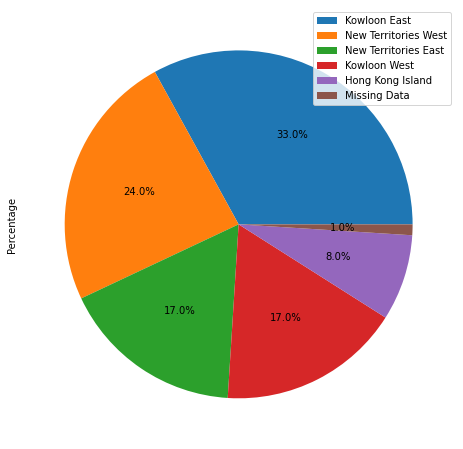

In [11]:
# Replacing the Nah value in the Living_District column by the value of "Missing Data"
# Extracting data from the Living_District column and counting its value to a new dataframe with a Frequency column and a Percentage column
data["Living_District"] = data["Living_District"].replace({None: "Missing Data"})
data_district = pd.DataFrame(data = data["Living_District"].value_counts())
data_district.columns = ["Frequency"]
data_district.insert(loc = 1, column = "Percentage", value = 0)

# Calculating the percentage for each district group from the Frequency column and inputting them into the Percentage column
# Printing the result after rounding the percentage
data_district["Frequency"], data_district["Percentage"] = np.array(data_district["Frequency"]), np.array(data_district["Percentage"])
data_district["Percentage"] = round(data_district["Frequency"] / data_district["Frequency"].sum(), 2)
print(data_district)

# Creating the related pie chart with the bmh style, the legend on the pie, the deactivation of labels, and the labelling of percentage 
data_district["Percentage"].plot(kind = "pie", style = "bmh", legend = True, labels = None, figsize = (8, 8), autopct='%1.1f%%')

Hence, the majority of the respondents are living in Kowloon and New Territories.

### Distribution of Order Times for LALAMOVE (within one month)

           Frequency  Percentage
0 time           157       0.748
1-3 times         26       0.124
4-6 times         16       0.076
7-9 times         11       0.052


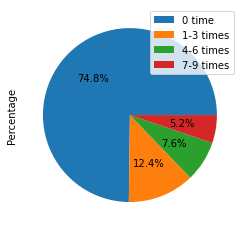

In [12]:
# Extracting data from the Times_LALAMOVE column and counting its value to a new dataframe with a Frequency column and a Percentage column
data_times_lalamove = pd.DataFrame(data = data["Times_LALAMOVE"].value_counts())
data_times_lalamove.columns = ["Frequency"]
data_times_lalamove.insert(loc = 1, column = "Percentage", value = 0)

# Calculating the percentage for each times group for LALAMOVE from the Frequency column and inputting them into the Percentage column
# Printing the result after rounding the percentage
data_times_lalamove["Frequency"], data_times_lalamove["Percentage"] = np.array(data_times_lalamove["Frequency"]), np.array(data_times_lalamove["Percentage"])
data_times_lalamove["Percentage"] = round(data_times_lalamove["Frequency"] / data_times_lalamove["Frequency"].sum(), 3)
print(data_times_lalamove)

# Creating the related pie chart with the bmh style, the legend on the pie, the deactivation of labels, and the labelling of percentage 
data_times_lalamove["Percentage"].plot(kind = "pie", style = "bmh", legend = True, labels = None, autopct='%1.1f%%')

Hence, only one-fourth of the respondents have used the LALAMOVE service at least once within one month before answering the questionnaire.

### Distribution of Order Times for GOGOVAN (within one month)

                   Frequency  Percentage
0 time                    12       0.057
1-3 times                 65       0.310
4-6 times                 53       0.252
7-9 times                 68       0.324
10 times of above         12       0.057


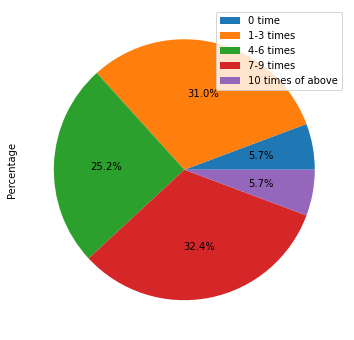

In [13]:
# Extracting data from the Times_GOGOVAN column and counting its value to a new dataframe with a Frequency column and a Percentage column
# Sorting the order by its times as the index
data_times_gogovan = pd.DataFrame(data = data["Times_GOGOVAN"].value_counts())
data_times_gogovan.columns = ["Frequency"]
data_times_gogovan = data_times_gogovan.reindex(["0 time", "1-3 times", "4-6 times", "7-9 times", "10 times of above"])
data_times_gogovan.insert(loc = 1, column = "Percentage", value = 0)

# Calculating the percentage for each times group for GOGOVAN from the Frequency column and inputting them into the Percentage column
# Printing the result after rounding the percentage
data_times_gogovan["Frequency"], data_times_gogovan["Percentage"] = np.array(data_times_gogovan["Frequency"]), np.array(data_times_gogovan["Percentage"])
data_times_gogovan["Percentage"] = round(data_times_gogovan["Frequency"] / data_times_gogovan["Frequency"].sum(), 3)
print(data_times_gogovan)

# Creating the related pie chart with the bmh style, the legend on the pie, the deactivation of labels, and the labelling of percentage 
data_times_gogovan["Percentage"].plot(kind = "pie", style = "bmh", legend = True, labels = None, figsize = (6, 6), autopct='%1.1f%%')

Hence, the majority of the respondents have used the GOGOVAN service at least once in the recent month before answering the questionnaire.

# Reliability and Validity

The reliability and validity of the survey instrument will be tested before conducting further analysis.

### Relaibility of Constructs

Cronbach's alpha will be used to test the relability of every construct.

In [14]:
# Inputting the function that forms the formula of Cronbach's alpha
def cronbach_alpha(df):
    df_corr = df.corr()
    N = df.shape[1]
    rs = np.array([])
    for i, col in enumerate(df_corr.columns):
        sum_ = df_corr[col][i+1:].values
        rs = np.append(sum_, rs)
    mean_r = np.mean(rs)
    cronbach_alpha = (N * mean_r) / (1 + (N - 1) * mean_r)
    return round(cronbach_alpha, 3)

In [15]:
# Creating a dataframe for the construct that each constitutes three questions
data_AA = pd.DataFrame(data = [data["AA1"], data["AA2"], data["AA3"]])
data_AA = data_AA.transpose()
data_BC = pd.DataFrame(data = [data["BC1"], data["BC2"], data["BC3"]])
data_BC = data_BC.transpose()
data_SC = pd.DataFrame(data = [data["SC1"], data["SC2"], data["SC3"]])
data_SC = data_SC.transpose()
data_PO = pd.DataFrame(data = [data["PO1"], data["PO2"], data["PO3"]])
data_PO = data_PO.transpose()
data_SF = pd.DataFrame(data = [data["SF1"], data["SF2"], data["SF3"]])
data_SF = data_SF.transpose()
data_TD = pd.DataFrame(data = [data["TD1"], data["TD2"], data["TD3"]])
data_TD = data_TD.transpose()
data_OR = pd.DataFrame(data = [data["OR1"], data["OR2"], data["OR3"]])
data_OR = data_OR.transpose()
data_CP = pd.DataFrame(data = [data["CP1"], data["CP2"], data["CP3"]])
data_CP = data_CP.transpose()
data_FM = pd.DataFrame(data = [data["FM1"], data["FM2"], data["FM3"]])
data_FM = data_FM.transpose()
data_SEC = pd.DataFrame(data = [data["SEC1"], data["SEC2"], data["SEC3"]])
data_SEC = data_SEC.transpose()
data_PRI = pd.DataFrame(data = [data["PRI1"], data["PRI2"], data["PRI3"]])
data_PRI = data_PRI.transpose()
data_SAT = pd.DataFrame(data = [data["SAT1"], data["SAT2"], data["SAT3"]])
data_SAT = data_SAT.transpose()

# Creating a list of factors that includes the name of constructs
factors = ["App aesthetics (AA)", "Booking convenience (BC)", "Service choice (BC)", "Price offerings (PO)", "System functionality (SF)", "Timeliness of delivery (TD)", "Order reliability (OR)", "Couriers performance (CP)", "Feedback mechanism (FM)", "Security (SEC)", "Privacy (PRI)", "Customer satisfaction (SAT)"]   

# Creating a dataframe that shows the Cronbach's alpha for each construct with its number of questions 
# Assigning the list of factors to be the index of the dataframe
data_reliability_test = pd.DataFrame(data = {"Cronbach's Alpha": [cronbach_alpha(data_AA), 
                                                                  cronbach_alpha(data_BC),
                                                                  cronbach_alpha(data_SC),
                                                                  cronbach_alpha(data_PO),
                                                                  cronbach_alpha(data_SF),
                                                                  cronbach_alpha(data_TD),
                                                                  cronbach_alpha(data_OR),
                                                                  cronbach_alpha(data_CP),
                                                                  cronbach_alpha(data_FM),
                                                                  cronbach_alpha(data_SEC),
                                                                  cronbach_alpha(data_PRI),
                                                                  cronbach_alpha(data_SAT)],
                                             "N of Items": 3},
                                     index = factors
                                    )

data_reliability_test

,Cronbach's Alpha,N of Items
App aesthetics (AA),0.923,3
Booking convenience (BC),0.886,3
Service choice (BC),0.891,3
Price offerings (PO),0.913,3
System functionality (SF),0.889,3
Timeliness of delivery (TD),0.898,3
Order reliability (OR),0.913,3
Couriers performance (CP),0.931,3
Feedback mechanism (FM),0.926,3
Security (SEC),0.912,3


The internal reliability of the variables are consistent and ranges from .883 to .931. Therefore, no items are required to delete.

### Validity of Questionnaire

The explortory factor analysis (EFA) will be used to test the validity of the survey instrument at the cross-constructs level. Questionnaire's data will be divided into three data set to test.

In [16]:
# Extracting the first data set to form a new dataframe
data_factor_analysis1 = pd.DataFrame(data = [data["SC2"], data["PO1"], data["PO3"], data["TD2"], data["SEC1"], data["SEC2"], data["SEC3"]])
data_factor_analysis1 = data_factor_analysis1.transpose()
data_factor_analysis1.head()

,SC2,PO1,PO3,TD2,SEC1,SEC2,SEC3
0,4.0,4.0,5.0,2.0,4.0,4.0,4.0
2,4.0,4.0,4.0,3.0,4.0,5.0,4.0
9,4.0,4.0,5.0,3.0,4.0,4.0,4.0
12,3.0,4.0,4.0,3.0,3.0,2.0,3.0
15,5.0,4.0,4.0,5.0,4.0,4.0,4.0


In [17]:
# Extracting the second data set to form a new dataframe
data_factor_analysis2 = pd.DataFrame(data = [data["AA2"], data["AA3"], data["OR2"], data["OR3"], data["FM2"], data["FM3"], data["SAT1"], data["SAT3"]])
data_factor_analysis2 = data_factor_analysis2.transpose()
data_factor_analysis2.head()

,AA2,AA3,OR2,OR3,FM2,FM3,SAT1,SAT3
0,4.0,3.0,4.0,4.0,4.0,5.0,4.0,4.0
2,4.0,4.0,3.0,3.0,3.0,5.0,4.0,4.0
9,4.0,2.0,3.0,5.0,2.0,2.0,4.0,5.0
12,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0
15,5.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0


In [18]:
# Extracting the third data set to form a new dataframe
data_factor_analysis3 = pd.DataFrame(data = [data["BC2"], data["BC3"], data["SF1"], data["SF3"], data["CP1"], data["CP3"], data["PRI1"], data["PRI2"], data["PRI3"]])
data_factor_analysis3 = data_factor_analysis3.transpose()
data_factor_analysis3.head()

,BC2,BC3,SF1,SF3,CP1,CP3,PRI1,PRI2,PRI3
0,4.0,3.0,4.0,2.0,3.0,4.0,3.0,3.0,4.0
2,4.0,4.0,4.0,4.0,3.0,3.0,4.0,4.0,4.0
9,4.0,5.0,4.0,4.0,4.0,4.0,4.0,2.0,4.0
12,3.0,4.0,4.0,4.0,3.0,3.0,2.0,3.0,3.0
15,5.0,5.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0


The EFA was supported by the principal component analysis as the extraction method with the varimax rotation and Kaiser normalization.

In [19]:
# Fitting the first data set in the FactorAnalyzer to filtering out questionnaire items with smaller coefficients
efa1 = FactorAnalyzer(n_factors = 4, rotation = "varimax", method = "principal")
efa1.fit(data_factor_analysis1)

# Creating a dataframe that shows the efa loadings of each question remained in the first data set
# Hiding coefficients less then or equal to 0.5
loadings1 = np.round(efa1.loadings_, 3)
df_efa1 = pd.DataFrame(data = loadings1, index = ["SC2", "PO1", "PO3", "TD2", "SEC1", "SEC2", "SEC3"], columns = ["Security", "Price Offerings", "Service choice", "Timeliness of delivery"])
df_efa1[df_efa1 > 0.5].replace({None: ""})

,Security,Price Offerings,Service choice,Timeliness of delivery
SC2,,,0.842,
PO1,,0.857,,
PO3,,0.723,,
TD2,,,,0.879
SEC1,0.824,,,
SEC2,0.784,,,
SEC3,0.859,,,


In [20]:
# Fitting the second data set in the FactorAnalyzer to filter out questionnaire items with smaller coefficients
efa2 = FactorAnalyzer(n_factors = 4, rotation = "varimax", method = "principal")
efa2.fit(data_factor_analysis2)

# Creating a dataframe that shows the efa loadings of each question remained in the second data set
# Hiding coefficients less then or equal to 0.5
loadings2 = np.round(efa2.loadings_, 3)
df_efa2 = pd.DataFrame(data = loadings2, index = ["AA2", "AA3", "OR2", "OR3", "FM2", "FM3", "SAT1", "SAT3"], columns = ["Customer satisfaction", "Feedback mechanism", "app aesthetics", "Order reliability"])
df_efa2[df_efa2 > 0.5].replace({None: ""})

,Customer satisfaction,Feedback mechanism,app aesthetics,Order reliability
AA2,,,0.822,
AA3,,,0.656,
OR2,,,,0.746
OR3,,,,0.765
FM2,,0.836,,
FM3,,0.781,,
SAT1,0.805,,,
SAT3,0.77,,,


In [21]:
# Fitting the third data set in the FactorAnalyzer to filter out questionnaire items with smaller coefficients
efa3 = FactorAnalyzer(n_factors = 4, rotation = "varimax", method = "principal")
efa3.fit(data_factor_analysis3)

# Creating a dataframe that shows the efa loadings of each question remained in the third data set
# Hiding coefficients less then or equal to 0.5
loadings3 = np.round(efa3.loadings_, 3)
df_efa3 = pd.DataFrame(data = loadings3, index = ["BC2", "BC3", "SF1", "SF3", "CP1", "CP3", "PRI1", "PRI2", "PRI3"], columns = ["Privacy", "System functionality", "Couriers performance", "Booking convenience"])
df_efa3[df_efa3 > 0.5].replace({None: ""})

,Privacy,System functionality,Couriers performance,Booking convenience
BC2,,,,0.855
BC3,,,,0.675
SF1,,0.773,,
SF3,,0.798,,
CP1,,,0.804,
CP3,,,0.791,
PRI1,0.835,,,
PRI2,0.877,,,
PRI3,0.801,,,


In [22]:
# Calculating total variance explained for each data_set aftering conducting EFA test
var_efa1 = np.round(efa1.get_factor_variance(), 5)[-1][-1]
var_efa2 = np.round(efa2.get_factor_variance(), 5)[-1][-1]
var_efa3 = np.round(efa3.get_factor_variance(), 5)[-1][-1]

print(f"Total variance explained for efa1 = {var_efa1}") 
print(f"Total variance explained for efa2 = {var_efa2}")
print(f"Total variance explained for efa3 = {var_efa3}") 

Total variance explained for efa1 = 0.91544
Total variance explained for efa2 = 0.91972
Total variance explained for efa3 = 0.89001


High total variance explained and the range of factor loading from 0.675 (BC3) to 0.879 (TD2) indicate that the majority of items with high factor loadings are properly loaded in their originated construct. For each construct, the number of items are not the same because some of the items with cross loadings are removed in the process of retesting EFA. The remaining items appropriately correspond to the constructs. 

Hence, to a certain extent, the validity of constructs is supported and paves the way to using four dimensions for multiple regression.

# Correlation and Regression Analysis

By considering 0.95 as the confidence level, correlation and regression analysis are conducted to check the significance of the overall model fit and the dimensions.

### Correlation Analysis for Constructs and Dimensions

Correlation analysis for 11 constructs will be conducted and correlation analysis for 4 higher-order dimensions will follow.

In [23]:
# Correlation analysis for 11 constructs 

# Reorganizing the content of constructs after relaibility and validity test
app_aesthetics = data["AA2"] + data["AA3"]
booking_convenience = data["BC2"] + data["BC3"]
service_choice = data["SC2"]
price_offerings = data["PO1"] + data["PO3"]
system_functionality = data["SF1"] + data["SF3"]
timeliness_of_delivery = data["TD2"]
order_reliability = data["OR2"] + data["OR3"]
couriers_performance = data["CP1"] + data["CP3"]
feedback_mechanism = data["FM2"] + data["FM3"]
security = data["SEC1"] + data["SEC2"] + data["SEC3"]
privacy = data["PRI1"] + data["PRI2"] + data["PRI3"]

customer_satisfaction = (data["SAT1"] + data["SAT3"]) / 2

# Forming the higher-order dimensions by gaining the mean of constructs for analysis
app_design = (app_aesthetics + booking_convenience + service_choice + price_offerings + system_functionality) / 9
delivery_fulfillment = (timeliness_of_delivery + order_reliability) / 3
customer_service = (couriers_performance + feedback_mechanism) / 4
security_or_privacy = (security + privacy) / 6

# Quantifying the control variables for multiple regression analysis
age_quantified = data["Age"]
age_quantified = age_quantified.replace({"18-30": 1, 
                                         "31-40": 2,
                                         "41-50": 3,
                                         "51-60": 4,
                                         "61 or above": 5
                                        })
monthly_income_quantified = data["Monthly_Income"]
monthly_income_quantified = monthly_income_quantified.replace({"<= 10000": 1,
                                                               "10000-15999": 2,
                                                               "16000-29999": 3,
                                                               "30000-39999": 4,
                                                               ">= 40000": 5
                                                              })

# Creating a dataframe that shows the r value of each constructs for correlaton analysis
data_correlation = pd.DataFrame(data = [app_aesthetics, booking_convenience, service_choice, price_offerings, system_functionality, timeliness_of_delivery, order_reliability, couriers_performance, feedback_mechanism, security, privacy])
data_correlation = data_correlation.transpose()
data_correlation.columns = ["App Aesthetics", "Booking Convenience", "Service Choice", "Price Offerings", "System Functionality", "Timeliness of Delivery", "Order Reliability", "Couriers Performance", "Feedback Mechanism", "Security", "Privacy"]
round(data_correlation.corr(), 3) 

,App Aesthetics,Booking Convenience,Service Choice,Price Offerings,System Functionality,Timeliness of Delivery,Order Reliability,Couriers Performance,Feedback Mechanism,Security,Privacy
App Aesthetics,1.000,0.800,0.758,0.808,0.736,0.694,0.774,0.720,0.749,0.661,0.680
Booking Convenience,0.800,1.000,0.824,0.791,0.752,0.595,0.773,0.684,0.660,0.654,0.582
Service Choice,0.758,0.824,1.000,0.672,0.698,0.603,0.758,0.615,0.595,0.620,0.532
Price Offerings,0.808,0.791,0.672,1.000,0.830,0.631,0.748,0.788,0.729,0.686,0.696
System Functionality,0.736,0.752,0.698,0.830,1.000,0.573,0.727,0.719,0.690,0.668,0.616
Timeliness of Delivery,0.694,0.595,0.603,0.631,0.573,1.000,0.721,0.696,0.699,0.583,0.585
Order Reliability,0.774,0.773,0.758,0.748,0.727,0.721,1.000,0.795,0.712,0.707,0.623
Couriers Performance,0.720,0.684,0.615,0.788,0.719,0.696,0.795,1.000,0.743,0.726,0.685
Feedback Mechanism,0.749,0.660,0.595,0.729,0.690,0.699,0.712,0.743,1.000,0.734,0.728
Security,0.661,0.654,0.620,0.686,0.668,0.583,0.707,0.726,0.734,1.000,0.795


The coefficients are ranging from 0.532 to 0.830. Hence, the 11 contructs are positively correlated with each other.

The r values between constructs under app design are generally higher from 0.7 to 0.8. This result indicates that the correlation between constructs under app design as a higher-level constructs was generally stronger.

In [24]:
# Inputting the function that calculates the p-value to check the significance of correlation
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = pearsonr(df[r], df[c])[1]
    return pvalues

# Creating a dataframe that shows p-value of each constructs
calculate_pvalues(data_correlation) 

,App Aesthetics,Booking Convenience,Service Choice,Price Offerings,System Functionality,Timeliness of Delivery,Order Reliability,Couriers Performance,Feedback Mechanism,Security,Privacy
App Aesthetics,0,4.92847e-48,2.10418e-40,9.18726e-50,4.66498e-37,1.62212e-31,4.04177e-43,7.15718e-35,5.08733e-39,1.05647e-27,8.18823e-30
Booking Convenience,4.92847e-48,0,3.82395e-53,3.43413e-46,1.87315e-39,1.78452e-21,6.20924e-43,2.4168e-30,1.30786e-27,5.53171e-27,1.97251e-20
Service Choice,2.10418e-40,3.82395e-53,0,5.45523e-29,4.7495e-32,3.29636e-22,1.74908e-40,3.35532e-23,1.69101e-21,1.02231e-23,9.39679e-17
Price Offerings,9.18726e-50,3.43413e-46,5.45523e-29,0,1.03122e-54,1.0016e-24,6.29253e-39,1.27993e-45,3.82762e-36,1.46773e-30,8.27323e-32
System Functionality,4.66498e-37,1.87315e-39,4.7495e-32,1.03122e-54,0,9.95524e-20,7.97517e-36,1.0562e-34,5.46076e-31,1.4917e-28,2.56583e-23
Timeliness of Delivery,1.62212e-31,1.78452e-21,3.29636e-22,1.0016e-24,9.95524e-20,0,5.71137e-35,8.30679e-32,3.53331e-32,1.58079e-20,1.04457e-20
Order Reliability,4.04177e-43,6.20924e-43,1.74908e-40,6.29253e-39,7.97517e-36,5.71137e-35,0,5.04514e-47,7.67322e-34,4.29544e-33,5.64124e-24
Couriers Performance,7.15718e-35,2.4168e-30,3.35532e-23,1.27993e-45,1.0562e-34,8.30679e-32,5.04514e-47,0,3.86877e-38,1.15031e-35,1.86222e-30
Feedback Mechanism,5.08733e-39,1.30786e-27,1.69101e-21,3.82762e-36,5.46076e-31,3.53331e-32,7.67322e-34,3.86877e-38,0,7.20858e-37,5.45843e-36
Security,1.05647e-27,5.53171e-27,1.02231e-23,1.46773e-30,1.4917e-28,1.58079e-20,4.29544e-33,1.15031e-35,7.20858e-37,0,5.63655e-47


All of the coefficents are less than 0.01. Hence, the constructs are significantly correlated with each other.

In [25]:
# Correlation analysis for 4 higher-order dimensions

# Creating a dataframe that shows the r-value of each higher-order dimension for correlaton analysis
data_corr_four_dimentions = pd.DataFrame(data = [app_design, delivery_fulfillment, customer_service, security_or_privacy])
data_corr_four_dimentions = data_corr_four_dimentions.transpose()
data_corr_four_dimentions.columns = ["App Design", "Delivery Fulfillment", "Customer Service", "Security or Privacy"]
round(data_corr_four_dimentions.corr(), 3) 

,App Design,Delivery Fulfillment,Customer Service,Security or Privacy
App Design,1.000,0.832,0.834,0.753
Delivery Fulfillment,0.832,1.000,0.842,0.716
Customer Service,0.834,0.842,1.000,0.812
Security or Privacy,0.753,0.716,0.812,1.000


The coefficients are ranging from 0.757 to 0.893. Hence, the four higher-order dimensions are positively correlated with each other.

The correlation between customer service and delivery fulfillment is the strongest, with the r value 0.893, while the correlation between security/privacy and booking app design is the weakest, with the r value 0.757.

In [26]:
calculate_pvalues(data_corr_four_dimentions) 

,App Design,Delivery Fulfillment,Customer Service,Security or Privacy
App Design,0,3.23302e-55,1.30374e-55,1.20032e-39
Delivery Fulfillment,3.23302e-55,0,1.15832e-57,2.33443e-34
Customer Service,1.30374e-55,1.15832e-57,0,1.83151e-50
Security or Privacy,1.20032e-39,2.33443e-34,1.83151e-50,0


The r value of these dimension is generally greater than 0.7 and is significant at p < 0.01 level. Hence, significantly high correlations between four dimensions indicated that it was possible to cause a multi-collinearity issue in multiple regression analysis so more statistics would be needed to double this issue.

### Multiple Regression Analysis with Control Variables

It is important to check whether the multi-collinearity issue is serious of not before conducting mutiple regression analysis.

In [27]:
# Creating a dataframe that shows a data set of customer satisfaction, the four dimensions, and two control variables
data_regression = pd.DataFrame(data = [customer_satisfaction, app_design, delivery_fulfillment, customer_service, security_or_privacy, age_quantified, monthly_income_quantified])
data_regression = data_regression.transpose()
data_regression.columns = ["Customer_Satisfaction", "App_Design", "Delivery_Fulfillment", "Customer_Service", "Security_or_Privacy", "Age", "Monthly_Income"]
data_regression

,Customer_Satisfaction,App_Design,Delivery_Fulfillment,Customer_Service,Security_or_Privacy,Age,Monthly_Income
0,4.0,3.666667,3.333333,4.00,3.666667,1.0,1.0
2,4.0,4.000000,3.000000,3.50,4.166667,2.0,2.0
9,4.5,4.000000,3.666667,3.00,3.666667,1.0,2.0
12,4.0,3.555556,3.666667,3.50,2.666667,1.0,1.0
15,4.0,4.555556,4.333333,4.00,4.166667,4.0,1.0
...,...,...,...,...,...,...,...
770,4.0,3.666667,3.333333,4.00,3.500000,2.0,3.0
772,3.5,3.666667,3.666667,3.75,3.000000,1.0,2.0
776,3.5,4.000000,3.000000,3.50,3.666667,1.0,2.0
777,4.0,4.000000,4.000000,4.00,4.000000,3.0,4.0


In [28]:
# Inputting the function that calculates the VIF values to check the collinearity statistics of this regression mode
def cal_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [round(variance_inflation_factor(X.values, i), 3) for i in range(X.shape[1])]
    vif["Tolerance"] = [round(1 / vif.iloc[i, 1], 3) for i in range(len(X.columns))]
    vif.set_index(keys = "variables", inplace = True)
    return(vif)

In [29]:
# Applying zscore to the data set
# Creating a dataframe with VIF values and tolerance level (1/VIF) by calling the cal_vif function
data_regression_beta = data_regression.apply(stats.zscore)
data_vif = cal_vif(data_regression_beta[["App_Design", "Delivery_Fulfillment", "Customer_Service", "Security_or_Privacy", "Age", "Monthly_Income"]])
data_vif.loc["App_Design": "Security_or_Privacy"]

,VIF,Tolerance
variables,,
App_Design,4.258,0.235
Delivery_Fulfillment,4.250,0.235
Customer_Service,5.558,0.180
Security_or_Privacy,3.123,0.320


The tolerance level of the four dimensions are higher than 0.1 and their VIF values are between 1 and 10. These results indicated that the multi-collinearity issue were not very serious as the collinearity statistics were within the acceptable range. Hence, multiple regression analysis can be further conducted.

In [30]:
# Setting up a model with two control variables for multiple regression analysis of customer satisfaction at stage one.
result1 = sm.ols(formula = "Customer_Satisfaction ~ Age + Monthly_Income", data = data_regression_beta).fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Customer_Satisfaction   R-squared:                       0.063
Model:                               OLS   Adj. R-squared:                  0.054
Method:                    Least Squares   F-statistic:                     6.953
Date:                   Sat, 03 Oct 2020   Prob (F-statistic):            0.00120
Time:                           22:38:02   Log-Likelihood:                -291.15
No. Observations:                    210   AIC:                             588.3
Df Residuals:                        207   BIC:                             598.3
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.815e-16      0.067    2.7e-15      1.000      -0.133       0.133
Age                0.0575      0.068      0.840      0.402      -0.077       0.193
Monthly_Income     0.2337      0.068      3.413      0.001       0.099       0.369
==============================================================================
Omnibus:                       51.141   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.493
Skew:                          -1.270   Prob(JB):                     6.08e-20
Kurtosis:                       4.913   Cond. No.                         1.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The overall model at stage one with two control variables is a significant predictor of customer satisfaction (F(2, 207) = 6.953, p < 0.05) and explains 6% of the variance (R-squared). It is found that monthly income (coef = 0.2337, p < 0.05) is a significant predictor of customer satisfaction but age (coef = 0.0575) is not a significant predictor of customer satisfaction at p = 0.5.

In [32]:
# Setting up a model with four dimensions and two control variables for multiple regression analysis of customer satisfaction at stage two.
result2 = sm.ols(formula = "Customer_Satisfaction ~ Monthly_Income + Age + App_Design + Delivery_Fulfillment + Customer_Service + Security_or_Privacy", data = data_regression_beta).fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Customer_Satisfaction   R-squared:                       0.781
Model:                               OLS   Adj. R-squared:                  0.775
Method:                    Least Squares   F-statistic:                     120.7
Date:                   Sat, 03 Oct 2020   Prob (F-statistic):           3.64e-64
Time:                           22:50:18   Log-Likelihood:                -138.50
No. Observations:                    210   AIC:                             291.0
Df Residuals:                        203   BIC:                             314.4
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.815e-16      0.033   5.53e-15      1.000      -0.065       0.065
Monthly_Income          -0.0147      0.035     -0.419      0.675      -0.084       0.054
Age                     -0.0429      0.034     -1.273      0.205      -0.109       0.024
App_Design               0.4660      0.068      6.876      0.000       0.332       0.600
Delivery_Fulfillment    -0.0351      0.068     -0.518      0.605      -0.169       0.098
Customer_Service         0.3648      0.077      4.712      0.000       0.212       0.517
Security_or_Privacy      0.1525      0.058      2.627      0.009       0.038       0.267
==============================================================================
Omnibus:                       14.772   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               23.411
Skew:                          -0.412   Prob(JB):                     8.25e-06
Kurtosis:                       4.413   Cond. No.                         5.21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It is revealed that the overall model at stage two with both control variables and four dimensions is a significant predictor of customer satisfaction (F(6, 203) = 120.7, p < 0.05) and explains 78.1% of the variance (R-squred). At stage two, it is found that app design is a significant predictor of customer satisfaction (coef = 0.4660, p < 0.05), as do customer service (coef = 0.3648, p < 0 .05) and security/privacy (coef = 0.1525, p < 0.05. However, the result indicates that delivery fulfillment (coef = -0.0351) is not a significant predictor at p = 0.05. As control variables, both age (coef = -0.0429) and monthly income (coef = -0.0147) at p = 0.05 do not shown significant results. Thus, most of the dimensions are significant in predicting customer satisfaction.

# Conclusion

<img src="conclusion.PNG">

Based on the above results, the above figure shows a multidimensional model with significant dimensions. The standardised coefficient (Beta) of app design (0.4660), customer service (0.3648), and security/privacy (0.1525) are both significant at p = 0.05 so the hypothesis 1, 3, and 4 are supported. However, as shown in the result2.summary(), the p-value of delivery fulfillment (Sig.) is 0.605, which is higher than 0.05, so this dimension does not show a significant result to support hypothesis 2. In other words, hypothesis 2 is rejected.